In [401]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmasher as cmr
import cartopy.crs as ccrs
from tools import set_hatch_color, format_lat_lon_ticks, parse_station_data

from mpl_toolkits.basemap import Basemap

import geopandas as gpd
import cartopy.feature as cfeature
from shapely.geometry import MultiPolygon, Polygon, Point
from shapely.ops import unary_union
import requests
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.dates as mdates
from subprocess import DEVNULL, STDOUT, check_call

In [404]:
imerg = xr.open_dataset("../data/external/gpm_merra2/NASA_GPM_L3_IMERG_V06_2024.nc").precipitationCal
imergp = xr.open_dataset("../data/external/gpm_merra2/percentiles_NASA_GPM_L3_IMERG_V06_apr_may.nc").precipitationCal

merra = xr.open_dataset("../data/external/gpm_merra2/NASA_GSFC_MERRA_slv_2_2024.nc")
merrap = xr.open_dataset("../data/external/gpm_merra2/percentiles_NASA_GSFC_MERRA_slv_2_apr_may.nc")

In [405]:
merra["SPD10M"] = np.sqrt(merra["U10M"]**2 + merra["V10M"]**2)

merra["U10Mn"] = merra["U10M"]/merra["SPD10M"]
merra["V10Mn"] = merra["V10M"]/merra["SPD10M"]

tslice = slice("2024-04-26", "2024-05-07")

merram = merra.sel(time=tslice).mean("time")
imergm = imerg.sel(time=tslice).mean("time")

dT10M = (merram.T10M-merrap.T10M)
dTQV = (merram.TQV-merrap.TQV)
dRain = (imergm-imergp)

In [406]:
merrap.sel(percentile=90).sel(lon=-50, lat=-20, method="nearest").T10M.values

array(300.93448, dtype=float32)

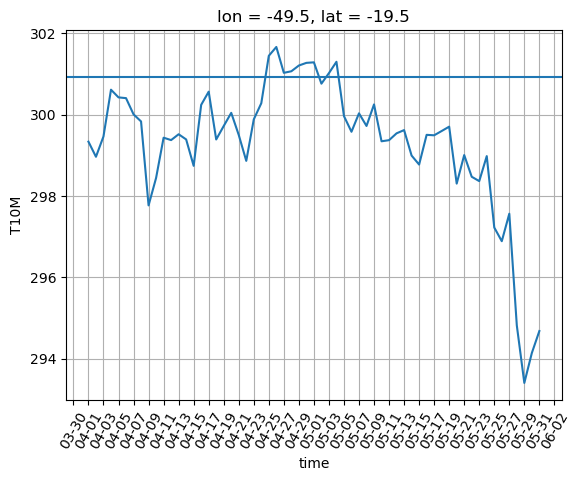

In [408]:
fig, ax = plt.subplots()
merra.sel(lon=-50, lat=-20, method="nearest").T10M.resample(time="1D").mean().plot()
ax.axhline(merrap.sel(percentile=90).sel(lon=-50, lat=-20, method="nearest").T10M.values)
# Set x-ticks every 2 days
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
# Optionally rotate the date labels for better readability
plt.xticks(rotation=60);
ax.grid(True)

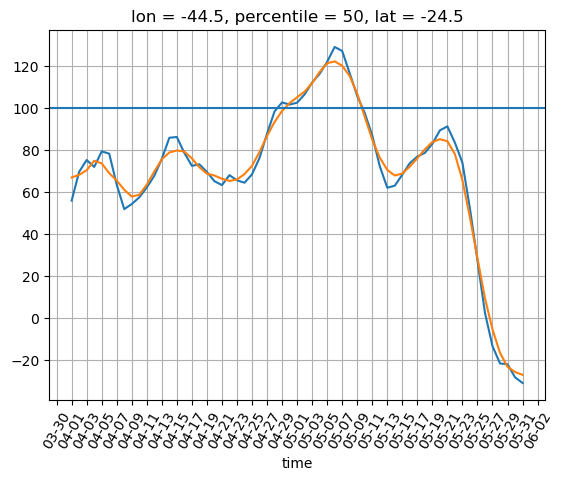

In [409]:
Z = -anomaly.H500*np.sin(45*np.pi/180)/np.sin(anomaly.lat*np.pi/180)
fig, ax = plt.subplots()
Z.sel(lon=-45, lat=-25, method="nearest").plot()
Z.sel(lon=-45, lat=-25, method="nearest").rolling(time=5, center=True, min_periods=1).mean().plot()
ax.axhline(100)
# Set x-ticks every 2 days
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
# Optionally rotate the date labels for better readability
plt.xticks(rotation=60);
ax.grid()

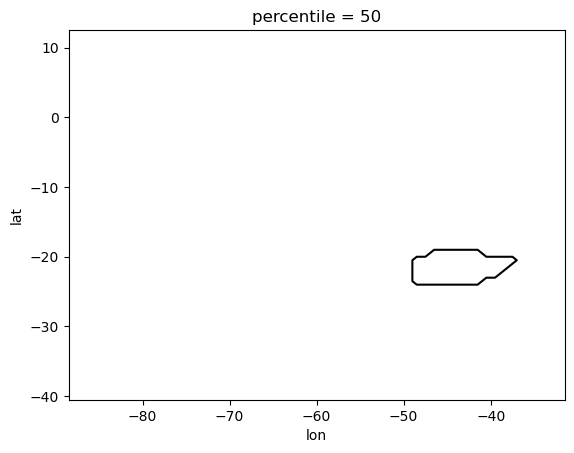

In [410]:
blocking = (
    ((Z.rolling(time=5, center=True, min_periods=1).mean()>100).sel(time=slice("2024-04-20", "2024-05-15")).sum("time")>10)&
    (Z.lat<-15)
)

C = blocking.plot.contour(levels=[0.5], colors="k");
xb,yb = C.allsegs[0][0].T

In [411]:
polygon = Polygon(zip(xb, yb))

# Define the x and y grid
x_grid, y_grid = np.meshgrid(Z.lon, Z.lat)

# Initialize the rasterized grid with zeros
raster = np.zeros(x_grid.shape, dtype=np.int)

# Rasterize the polygon
for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        point = Point(x_grid[i, j], y_grid[i, j])
        if polygon.contains(point):
            raster[i, j] = 1

mask = (xr.ones_like(Z.isel(time=0))*raster).astype("bool")

/tmp/ipykernel_5285/2862451734.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raster = np.zeros(x_grid.shape, dtype=np.int)


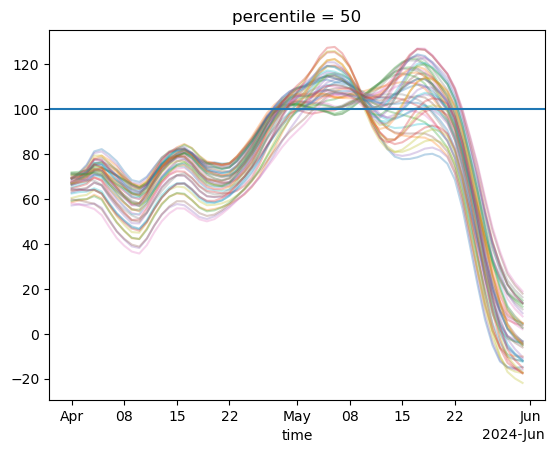

In [412]:
fig, ax = plt.subplots()
(
    Z.rolling(time=5, center=True, min_periods=1).mean()
    .where(mask).stack(obs=["lon", "lat"])
    .dropna("obs").drop_vars("obs")
).plot.line(x="time", hue="obs", add_legend=False, alpha=0.3);
ax.axhline(100)

In [287]:
lons = imerg.lon.quantile([0,1]).values
lats = imerg.lat.quantile([0,1]).values

# Define a bounding box encompassing the entire American continent
bbox = Polygon([
    (lons[0], lats[0]),
    (lons[1], lats[0]),
    (lons[1], lats[1]),
    (lons[0], lats[1])
])

# Get the COASTLINE feature (high resolution recommended)
coastline = cfeature.COASTLINE.with_scale("10m")

# Filter coastlines within the American continent bounding box
selected_coastlines = []
for geometry in coastline.geometries():
    if bbox.intersects(geometry):
        selected_coastlines.append(geometry)

selected_coastlines = unary_union(selected_coastlines)


gdf = gpd.read_file("../data/external/shapefiles/RS_Municipios_2022")

rs_shape = gdf.geometry.unary_union

/home/iury/projects/swot_southbrazil_flooding/src/tools.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_xticklabels)
/home/iury/projects/swot_southbrazil_flooding/src/tools.py:190: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_yticklabels)


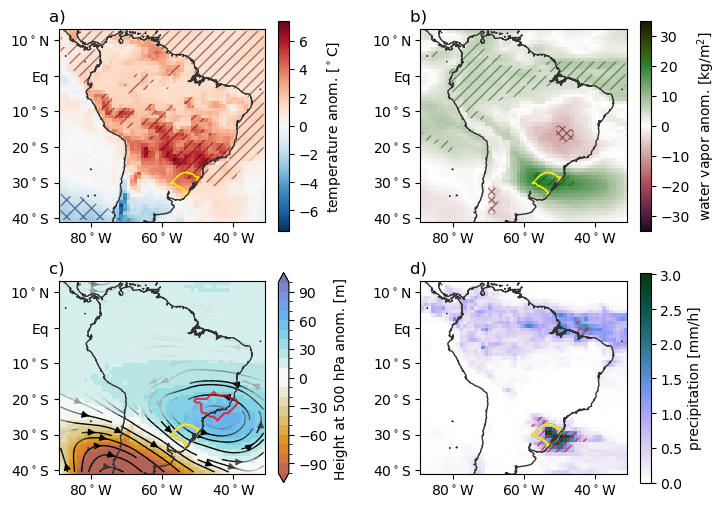

In [313]:
kw = {
    "hatch": {
        "levels": [0.5, 1.5],
        "extend": "neither",
        "colors": "none",
        "add_colorbar": False,
    }
}

fig, ax = plt.subplots(2, 2, figsize=(8, 6))
fig.subplots_adjust(wspace=0.4)
ax = np.hstack(ax)

dT10M.sel(percentile=50).plot(ax=ax[0], cbar_kwargs=dict(ticks=np.arange(-6,8,2), label="temperature anom. [$^\circ$C]"))
cs = (dT10M.sel(percentile=20)<0).plot.contourf(ax=ax[0], hatches=["xx"], **kw["hatch"])
set_hatch_color(cs, (0,0,0.3,0.5))
cs = (dT10M.sel(percentile=80)>0).plot.contourf(ax=ax[0], hatches=["///"], **kw["hatch"])
set_hatch_color(cs, (0.3,0,0,0.5))

dTQV.sel(percentile=50).plot(ax=ax[1], cmap="cmr.holly_r", vmin=-35, vmax=35, cbar_kwargs=dict(label="water vapor anom. [kg/m$^2$]"))
cs = (dTQV.sel(percentile=20)<0).plot.contourf(ax=ax[1], hatches=["xxxx"], **kw["hatch"])
set_hatch_color(cs, (0.3,0,0,0.5))
cs = (dTQV.sel(percentile=90)>0).plot.contourf(ax=ax[1], hatches=["///"], **kw["hatch"])
set_hatch_color(cs, (0,0.3,0,0.5))

# merram.SPD10M.plot(ax=ax[2],vmin=0, vmax=6, cmap="cmr.bubblegum_r", alpha=0.8,
#                    cbar_kwargs=dict(label="wind speed [m/s]"))
# merram.plot.streamplot(
#     ax=ax[2],
#     x="lon", y="lat",
#     u="U10Mn", v="V10Mn",
#     density=0.8, linewidth=1,
#     color="0.9"
# )
dsi = (merram-merrap.sel(percentile=50))
dsi = dsi.assign(SPD500 = np.sqrt(dsi.U500**2 + dsi.V500**2))
dsi.H500.plot(ax=ax[2], cmap="cmr.prinsenvlag", vmin=100, vmax=100, levels=np.arange(-100,110,10), extend="both", alpha=0.9, cbar_kwargs=dict(label="Height at 500 hPa anom. [m]"))
dsi.plot.streamplot(ax=ax[2],x="lon", y="lat", u="U500", v="V500", hue="SPD500", cmap=cmap, vmin=2, vmax=8, add_guide=False, linewidth=1)
ax[2].plot(xb, yb, "#ff000dbf")

imergm.plot(ax=ax[3], x="lon", y="lat", cmap="cmr.horizon_r", cbar_kwargs=dict(label="precipitation [mm/h]"))
cs = (dRain.sel(percentile=90)>0.5).plot.contourf(ax=ax[3], hatches=["////"], **kw["hatch"])
set_hatch_color(cs, "#ff000dbf")

[a.set(xlabel="", ylabel="", title=f"{lb})"+40*" ") for a, lb in zip(ax,"a b c d".split())]
[a.axis("scaled") for a in ax];
for i, a in enumerate(ax):
    for polygon in rs_shape.geoms:
        x, y = np.vstack(polygon.exterior.coords).T
        if i >= 2:
            a.plot(x, y, color="0.7", lw=2, alpha=0.9)
        a.plot(x, y, color="#fff000ff", lw=1, alpha=0.9)
    for line in selected_coastlines.geoms:
        x, y = line.xy
        a.plot(x, y, color="0.2", lw=1)
    format_lat_lon_ticks(a, decimals=0)
        
# [a.set(xlabel="longitude") for a in ax[2:]];
# [a.set(ylabel="latitude") for a in ax[::2]];

fig.savefig("../img/large_scale.png", dpi=300, facecolor="w", bbox_inches="tight")


In [341]:
anomaly = (merra-merrap.sel(percentile=50)).resample(time="1D").mean().rolling(time=5, center=True, min_periods=1).mean()
imergd = imerg.resample(time="1D").sum().sel(time=anomaly.time).rolling(time=5, center=True, min_periods=1).mean()

In [345]:
kw = {
    "hatch": {
        "levels": [0.5, 1.5],
        "extend": "neither",
        "colors": "none",
        "add_colorbar": False,
    }
}

for i in tqdm(np.arange(20, 50, 1)):
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))
    fig.subplots_adjust(wspace=0.4)
    ax = np.hstack(ax)

    time = anomaly.time.values[i]
    ax[1].text(-0.3, 1.1, str(time).split("T")[0], transform=ax[1].transAxes, ha="center")
    
    anomaly.T10M.isel(time=i).plot(ax=ax[0], vmin=-6, vmax=8, cmap="cmr.fusion_r", cbar_kwargs=dict(ticks=np.arange(-6,8,2), label="temperature anom. [$^\circ$C]"))
    
    anomaly.TQV.isel(time=i).plot(ax=ax[1], cmap="cmr.holly_r", vmin=-35, vmax=35, cbar_kwargs=dict(label="water vapor anom. [kg/m$^2$]"))
    
    anomaly.H500.isel(time=i).plot(ax=ax[2], cmap="cmr.viola", vmin=-120, vmax=120, levels=np.arange(-120,120,10), alpha=0.9, cbar_kwargs=dict(label="Height at 500 hPa anom. [m]"))
    ax[2].plot(xb, yb, "#ff000dbf")
    
    imergd.isel(time=i).plot(ax=ax[3], vmin=0, vmax=300, x="lon", y="lat", cmap="cmr.horizon_r", cbar_kwargs=dict(label="daily precipitation [mm]"))
    
    [a.set(xlabel="", ylabel="", title=f"{lb})"+40*" ") for a, lb in zip(ax,"a b c d".split())]
    [a.axis("scaled") for a in ax];
    for j, a in enumerate(ax):
        for polygon in rs_shape.geoms:
            x, y = np.vstack(polygon.exterior.coords).T
            if j >= 2:
                a.plot(x, y, color="0.7", lw=2, alpha=0.9)
            a.plot(x, y, color="#fff000ff", lw=1, alpha=0.9)
        for line in selected_coastlines.geoms:
            x, y = line.xy
            a.plot(x, y, color="0.2", lw=1)
        format_lat_lon_ticks(a, decimals=0)


    fig.savefig(f"../img/video/{i:05d}.png", dpi=300)
    plt.close("all")

100%|███████████████████████████████████████████| 30/30 [01:26<00:00,  2.88s/it]


In [346]:
video_name = "output"
ffmpeg_command = [
    "ffmpeg",
    "-y",
    "-framerate", "3",
    "-pattern_type", "glob",
    "-i", f"../img/video/*.png",  # Assuming opath is correctly defined
    "-c:v", "libx264",
    "-preset", "veryslow",
    "-crf", "0",
    "-pix_fmt", "yuv420p",
    f"../img/{video_name}.mp4"  # Assuming video_name is also defined
]
check_call(ffmpeg_command, stdout=DEVNULL, stderr=STDOUT)

0

In [390]:
d50 = xr.open_dataset("../data/external/gpm_merra2/percentiles_NASA_GSFC_MERRA_slv_2_apr_may_extended.nc").sel(percentile=50).H500
H500 = xr.open_dataset("../data/external/gpm_merra2/NASA_GSFC_MERRA_slv_2_extended_2024.nc").H500
factor = (np.sin(-45*np.pi/180)/np.sin(Z.lat*np.pi/180))
Z = (H500.resample(time="1D").mean()-d50).rolling(time=5, center=True, min_periods=1).mean()*factor

/tmp/ipykernel_5285/645962186.py:9: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  m.pcolor(x, y, Z.where(Z.lat<-15).sel(time=tslice).median("time").values, vmin=-300, vmax=300, cmap="cmr.fusion")


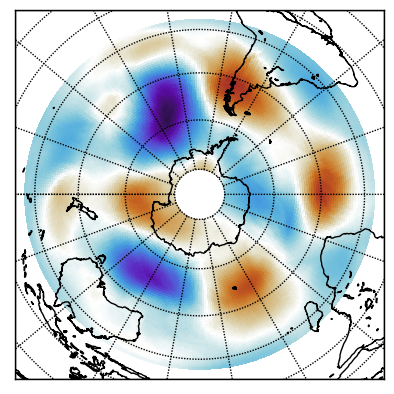

In [398]:

m = Basemap(projection='splaea',boundinglat=-10,lon_0=90,resolution='l')
m.drawcoastlines()
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary() 

x,y = m(*np.meshgrid(Z.lon, Z.lat))
m.pcolor(x, y, Z.where(Z.lat<-15).sel(time=tslice).median("time").values, vmin=-300, vmax=300, cmap="cmr.fusion")